# Combined Simplex Removal: Non-convex + Same-side

This notebook demonstrates removing two types of simplices:
1. **Non-convex** - Adjacent crossing simplices where the SVM boundary is not convex
2. **Same-side** - Sibling simplices that all fall on the same side of the decision boundary


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import sys
import os

current_dir = os.getcwd()
parent_dir = os.path.join(current_dir, '..', '..')
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)

from in2D.classifying.classes.simplex_tree_classifier import SimplexTreeClassifier
from in2D.classifying.classes.utilss.convexity_check import check_convexity, get_shared_vertices


In [2]:
def make_meshgrid(x, y, h=0.01):
    x_min, x_max = x.min(), x.max()
    y_min, y_max = y.min(), y.max()
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    return xx, yy

def plot_contours(ax, clf, xx, yy, xy, **params):
    Z = clf.predict(xy)
    Z = Z.reshape(xx.shape)
    return ax.contourf(xx, yy, Z, **params)


## 1. Create Dataset

In [3]:
N = 1000
C = 1000
gamma = 0.01
D = 2
t = 8

X = np.random.normal(0, 1, (N, D))
ws = np.random.normal(0, 1, (t, D))
ws = ws / np.linalg.norm(ws, axis=1).reshape(-1, 1)

u = np.random.uniform(0, 1, (N, 1))
X = X / np.linalg.norm(X, axis=1).reshape(-1, 1) * (u ** (1/D))

y = np.ones(N)
for index in range(N):
    z = 1
    for w in ws:
        if (X[index].dot(w) - 0.5 - gamma) > 0:
            z = -1
        elif (X[index].dot(w) - 0.4 - gamma) > 0:
            z = 0
    y[index] = z

X = (X[y != 0] + [1, 1]) / 2
y = y[y != 0]

print(f"Dataset: {X.shape[0]} points, Classes: {np.unique(y)}")


Dataset: 805 points, Classes: [-1.  1.]


## 2. Build Model


In [4]:
margin = 0.05
data_x_min, data_x_max = X[:, 0].min() - margin, X[:, 0].max() + margin
data_y_min, data_y_max = X[:, 1].min() - margin, X[:, 1].max() + margin

root_vertices = [
    (data_x_min, data_y_min),
    (data_x_max + (data_x_max - data_x_min), data_y_min),
    (data_x_min, data_y_max + (data_y_max - data_y_min))
]

subdivision_levels = 3
model = SimplexTreeClassifier(
    vertices=root_vertices,
    regularization=C,
    subdivision_levels=subdivision_levels,
    classifier_type='linear_svc'
)
model.fit(X, y)

x_min, x_max = data_x_min - 0.05, data_x_max + 0.05
y_min, y_max = data_y_min - 0.05, data_y_max + 0.05
xx, yy = make_meshgrid(np.linspace(x_min, x_max, 200), np.linspace(y_min, y_max, 200))

print(f"Model built with {len(model.leaf_simplexes)} leaf simplices")


(805, 16)
Model built with 27 leaf simplices


## 3. Find Simplices to Remove

- **Non-convex**: Adjacent crossing simplices where the average point falls on wrong side
- **Same-side**: All siblings on same side of decision boundary

In [5]:
weights = model.classifier.coef_[0]
intercept = model.classifier.intercept_[0]
EPSILON = 0.10

nonconvex_simplex_keys = set()
crossing_simplices = model.identify_svm_crossing_simplices()

for i, info1 in enumerate(crossing_simplices):
    simplex1 = info1['simplex']
    for info2 in crossing_simplices[i+1:]:
        simplex2 = info2['simplex']
        shared = get_shared_vertices(simplex1, simplex2)
        if len(shared) >= 2:
            is_convex, avg, meeting, pt1, pt2 = check_convexity(
                simplex1, simplex2, weights, intercept,
                global_tree=model.tree, epsilon=EPSILON
            )
            if not is_convex:
                nonconvex_simplex_keys.add(frozenset(simplex1.vertex_indices))
                nonconvex_simplex_keys.add(frozenset(simplex2.vertex_indices))

same_side_simplex_keys = model.find_same_side_simplices()
combined_keys = nonconvex_simplex_keys.union(same_side_simplex_keys)

print(f"Non-convex simplices: {len(nonconvex_simplex_keys)}")
print(f"Same-side simplices: {len(same_side_simplex_keys)}")
print(f"Combined (union): {len(combined_keys)}")
print(f"Leaves before removal: {len(model.tree.get_leaves())}")

Non-convex simplices: 8
Same-side simplices: 9
Combined (union): 17
Leaves before removal: 27


## 4. Visualize and Remove

- **Green** = Non-convex only
- **Yellow** = Same-side only
- **Purple** = Both

(805, 16)
Removed 17 simplices
Leaves after removal: 13


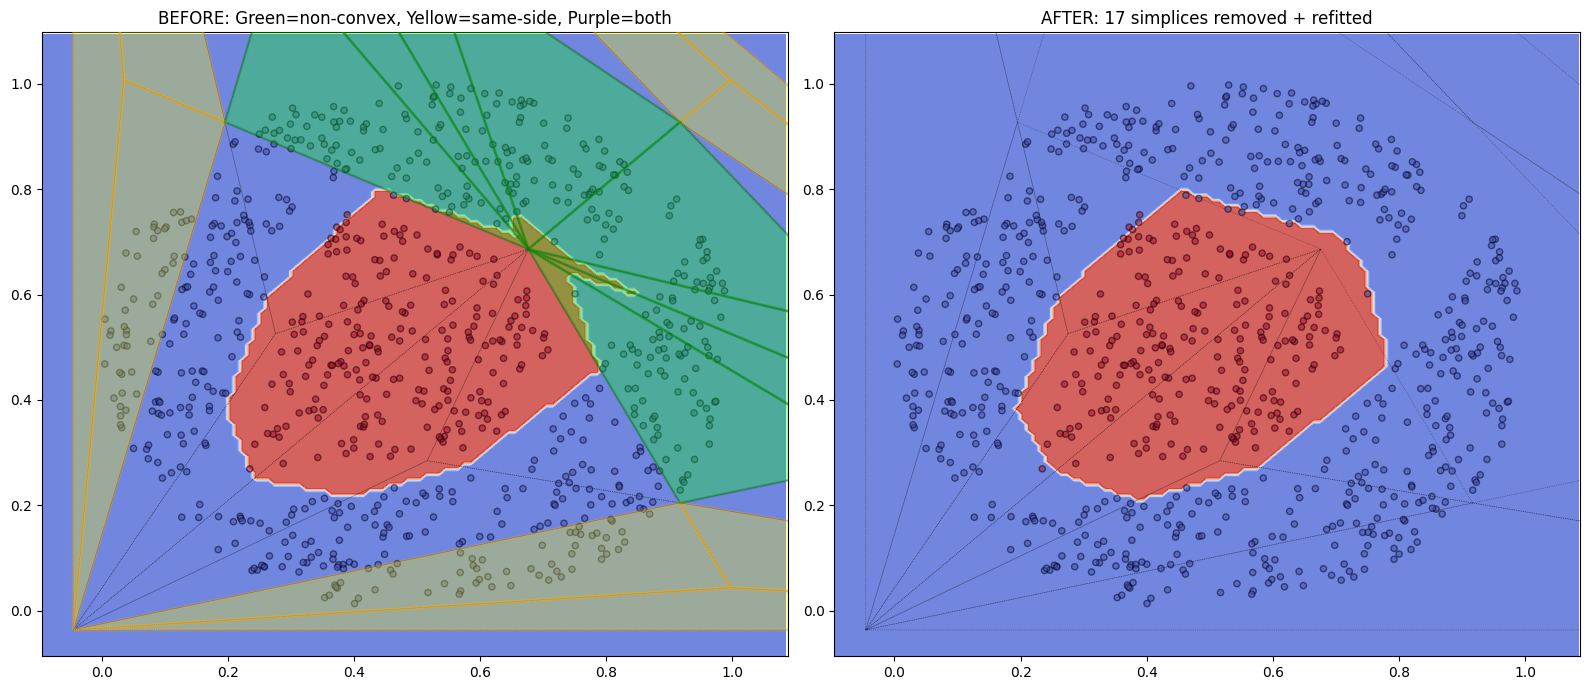

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

ax = axes[0]
xy_before = model.transform(np.vstack([xx.ravel(), yy.ravel()]).T)
plot_contours(ax, model.classifier, xx, yy, xy_before, cmap=plt.cm.coolwarm, alpha=0.8)
for boundary in model.get_simplex_boundaries():
    if len(boundary) >= 3:
        closed = boundary + [boundary[0]]
        bx, by = zip(*closed)
        ax.plot(bx, by, 'k', linestyle=':', linewidth=0.5, alpha=0.5)
for leaf in model.tree.get_leaves():
    simplex_key = frozenset(leaf.vertex_indices)
    is_nonconvex = simplex_key in nonconvex_simplex_keys
    is_same_side = simplex_key in same_side_simplex_keys
    if is_nonconvex and is_same_side:
        color, edge = 'purple', 'darkviolet'
    elif is_nonconvex:
        color, edge = 'lime', 'green'
    elif is_same_side:
        color, edge = 'yellow', 'orange'
    else:
        continue
    vertices = np.array(leaf.vertices)
    poly = patches.Polygon(vertices, closed=True, facecolor=color, alpha=0.3, edgecolor=edge, linewidth=2, zorder=6)
    ax.add_patch(poly)
ax.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k', alpha=0.5)
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
ax.set_title("BEFORE: Green=non-convex, Yellow=same-side, Purple=both")

removed_count = 0
for simplex_key in combined_keys:
    if model.tree.remove_simplex_by_key(simplex_key):
        removed_count += 1
model._build_node_lookup()
model.fit(X, y)
print(f"Removed {removed_count} simplices")
print(f"Leaves after removal: {len(model.tree.get_leaves())}")

ax = axes[1]
xy_after = model.transform(np.vstack([xx.ravel(), yy.ravel()]).T)
plot_contours(ax, model.classifier, xx, yy, xy_after, cmap=plt.cm.coolwarm, alpha=0.8)
for leaf in model.tree.get_leaves():
    vertices = leaf.get_vertices_as_tuples()
    if len(vertices) >= 3:
        closed = vertices + [vertices[0]]
        bx, by = zip(*closed)
        ax.plot(bx, by, 'k', linestyle=':', linewidth=0.5, alpha=0.5)
ax.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k', alpha=0.5)
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
ax.set_title(f"AFTER: {removed_count} simplices removed + refitted")

plt.tight_layout()
plt.show()


In [7]:
model.tree.print_tree()

└── (-0.05, -0.04), (2.12, -0.04), (-0.05, 2.13)
    ├── (-0.05, -0.04), (2.12, -0.04), (0.68, 0.69)
    │   ├── (-0.05, -0.04), (2.12, -0.04), (0.92, 0.20)
    │   ├── (2.12, -0.04), (0.68, 0.69), (0.92, 0.20)
    │   │   └── (0.92, 0.20), (2.12, -0.04), (1.24, 0.28)
    │   └── (0.68, 0.69), (-0.05, -0.04), (0.92, 0.20)
    │       ├── (0.68, 0.69), (-0.05, -0.04), (0.52, 0.28)
    │       ├── (-0.05, -0.04), (0.92, 0.20), (0.52, 0.28)
    │       └── (0.92, 0.20), (0.68, 0.69), (0.52, 0.28)
    ├── (2.12, -0.04), (-0.05, 2.13), (0.68, 0.69)
    │   ├── (2.12, -0.04), (-0.05, 2.13), (0.92, 0.93)
    │   ├── (-0.05, 2.13), (0.68, 0.69), (0.92, 0.93)
    │   │   └── (0.92, 0.93), (-0.05, 2.13), (0.52, 1.25)
    │   └── (0.68, 0.69), (2.12, -0.04), (0.92, 0.93)
    │       └── (2.12, -0.04), (0.92, 0.93), (1.24, 0.53)
    └── (-0.05, 2.13), (-0.05, -0.04), (0.68, 0.69)
        ├── (-0.05, 2.13), (-0.05, -0.04), (0.20, 0.93)
        ├── (-0.05, -0.04), (0.68, 0.69), (0.20, 0.93)
        